# Introduction

# Libraries

In [3]:
import requests
import os
import pandas as pd
pd.options.display.max_columns = None
import seaborn as sns
sns.set_style('dark')
pal = 'crest'
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.stats.multicomp as mc

from sklearn.preprocessing import OrdinalEncoder

# User Definitions

## OrdinalEncoder Lists

In [6]:
edu_order = [
    'No Formal quals',
    'Lower Than A Level',
    'A Level or Equivalent',
    'HE Qualification',
    'Post Graduate Qualification'
]
imd_order = [
    '0-10%',
    '10-20%',
    '20-30%',
    '30-40%',
    '40-50%',
    '50-60%',
    '60-70%',
    '70-80%',
    '80-90%',
    '90-100%'
]
age_order = [
    '0-35',
    '35-55',
    '55<='
]

# Data

## Citation
Kuzilek, J., Hlosta, M., Herrmannova, D., Zdrahal, Z. and Wolff, A. OU Analyse: Analysing At-Risk Students at The Open University. Learning Analytics Review, no. LAK15-1, March 2015, ISSN: 2057-7494.
source: http://archive.ics.uci.edu/ml/datasets/Open+University+Learning+Analytics+dataset

Data found: https://www.kaggle.com/datasets/thedevastator/open-university-learning-analytics-dataset?resource=download

In [9]:
assess = pd.read_csv('./data/assessments.csv', na_values = '?', low_memory = False)
courses = pd.read_csv('./data/courses.csv', na_values = '?', low_memory = False)
stassess = pd.read_csv('./data/studentAssessment.csv', na_values = '?', low_memory = False)
stinfo = pd.read_csv('./data/studentInfo.csv', na_values = '?', low_memory = False)
streg = pd.read_csv('./data/studentRegistration.csv', na_values = '?', low_memory = False)
stvle = pd.read_csv('./data/studentVle.csv', na_values = '?', low_memory = False)
vle = pd.read_csv('./data/vle.csv', na_values = '?', low_memory = False)

In [10]:
ls_all_docs = [assess, courses, stassess, stinfo, streg, stvle, vle]
assess.name = 'assess'
courses.name = 'courses'
stassess.name = 'stassess'
stinfo.name = 'stinfo'
streg.name = 'streg'
stvle.name = 'stvle'
vle.name = 'vle'

## Features
* age_band: Band of the student's age
* assessment_type: Type of assessment
* code_module: Code name of the module, which serves as the identifier
* code_presentation: Code name of the presentation. It consists of the year and B for the presentation starting in February and J for the presentation starting in October
* date: Information about the final submission date of the assessment calculated as the number of days since the start of the module-presentation. The starting date of the presentation has number 0 (zero)
* date_registration: The date of student's registration on the module presentation, this is the number of days measured relative to the start of the module-presentation (e.g. the negative value -30 means that the student registered to module presentation 30 days before it started)
* date_submitted: The date of student submission, measured as the number of days since the start of the module presentation
* date_unregistration: Date of student unregistration from the module presentation, this is the number of days measured relative to the start of the module-presentation. Students, who completed the course have this field empty. Students who unregistered have Withdrawal as the value of the final_result column in the studentInfo.csv file
* disability: Indicates whether the student has declared a disability
* final_result: Student's final result in the module-presentation
* gender: The student's gender
* highest_education: Highest student education level on entry to the module presentation
* id_assessment: Identification number of the assessment
* id_site: An identification number
* id_student: A unique identification number for the student
* imd_band: Specifies the Index of Multiple Deprivation band of the place where the student lived during the module-presentation
* is_banked: A status flag indicating that the assessment result has been transferred from a previous presentation
* length: Length of the module-presentation in days
* num_of_prev_attempts: The number of times the student has attempted this module
* region: Identifies the geographic region, where the student lived while taking the module-presentation
* score: The student's score in this assessment. The range is from 0 to 100. The score lower than 40 is interpreted as Fail. The marks are in the range from 0 to 100
* studied_credits: The total number of credits for the modules the student is currently studying
* sum_click: The number of times a student interacts with the material in that day
* weight: Weight of the assessment in %. Typically, Exams are treated separately and have the weight 100%; the sum of all other assessments is 100%
* week_from: The week from which the material is planned to be used
* week_to: Week until which the material is planned to be useday 100iononcsv filetarted)ionnon100%(zero)oberr

In [12]:
for doc in ls_all_docs:
    print(f'{doc.name}: {doc.shape}')
    print(doc.head(), '\n')
    print(doc.info(), '\n')
    print(doc.describe(), '\n')
    print(doc.isna().sum(), '\n')
    print('------------------------------------------- \n')

assess: (206, 6)
  code_module code_presentation  id_assessment assessment_type   date  weight
0         AAA             2013J           1752             TMA   19.0    10.0
1         AAA             2013J           1753             TMA   54.0    20.0
2         AAA             2013J           1754             TMA  117.0    20.0
3         AAA             2013J           1755             TMA  166.0    20.0
4         AAA             2013J           1756             TMA  215.0    30.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64

# Data Pre-Cleaning

The goal for pre-cleaning is to deal with any typos or missing values in each feature. For the available datasets, only five datasets needed pre-cleaning: assess, stassess, stinfo, streg, and vle.

## Assessment

The assess dataset only had missing data associated with the 'date' feature. Since the assessment dataset characterizes the assignments in the other datasets, the values would be best imputed rather than having the rows dropped. The max date will be used to impute the feature because that is hypothetically the last day of the module to turn in any work.

In [15]:
assess2 = assess.copy()
assess2['date'] = assess2['date'].fillna(assess2['date'].max())

## Student Assessment

The student assessment dataset is missing about 0.09% of the observations' scores. With such a small proportion missing of a large dataset, the observations should be ok to drop. Additionally, many of the observations in the dataset are the same student across multiple assignments. Observations are expected to be aggregated by student in later analysis, so this loss of data should be minimally impactful to the final predictions.

In [17]:
stassess2 = stassess.dropna()

## Student Info

The student information dataset provides characteristics for each of the students registered for the module. The only typo that was identified was that '10-20' imd band. The index of multiple depravation band could be thought of as almost a financial bracket that categorizes regions of the country. I chose to add the percent to match the other values. This category was also the only feature that was missing data. In here the discrete categorical variable was imputed with the mode value of the feature. 

In [19]:
stinfo2 = stinfo.copy()
stinfo2.loc[(stinfo2['imd_band'] == '10-20'), 'imd_band'] = stinfo2['imd_band'] + '%'
most_common = stinfo2['imd_band'].mode()[0]
stinfo3 = stinfo2.copy()
stinfo3['imd_band'].fillna(value = most_common, inplace = True)

## Student Registration

The student registration had most of its missing values in the 'date_unregistration' feature because this signaled the date that students unregistered from the module relative to the start of the module. Removing this feature should not impact the study because although it is a mechanism for categorizing students as withdrawn, it is not a root cause of a student withdrawing.

In [21]:
streg2 = streg.drop(columns = 'date_unregistration')
streg3 = streg2.dropna()

## Virtual Learning Environment

The characterization of the vle start and end dates is irrelevant to whether students should pass or fail. Therefore the features were removed to reduce the dimensionality of the model.

In [23]:
vle2 = vle.drop(columns = ['week_from', 'week_to'])

# Merging

In [25]:
as_co = assess2.merge(courses, on = ['code_module', 'code_presentation'])
sta_ac = stassess2.merge(as_co, on = 'id_assessment')
in_re = stinfo3.merge(streg3, on = ['code_module', 'code_presentation', 'id_student'])
sv_vl = stvle.merge(vle2, on = ['id_site', 'code_module', 'code_presentation'])
sacri = sta_ac.merge(in_re, on = ['code_module', 'code_presentation', 'id_student'])
df1 = sv_vl.merge(sacri, on = ['code_module', 'code_presentation', 'date', 'id_student'])

# Cleaning

## Reordering Features

Features are reordered to group student identifiers, assignment identifiers, and student interactions together.

In [28]:
col_order = ['id_student','gender', 'disability', 'age_band', 
             'region', 'imd_band', 'highest_education', 'id_site', 
             'code_module', 'code_presentation', 'id_assessment', 
             'date_registration', 'num_of_prev_attempts', 
             'studied_credits', 'date_submitted', 'score',
             'assessment_type', 'module_presentation_length', 
             'weight', 'is_banked',  'activity_type', 'date',
             'sum_click','final_result']
df2 = df1[col_order]

## Binary Encoding

The 'gender' and 'disability' features were converted to binary encodings. Disabilities were directly translated into binary. Gender was arbitrarily assigned 0 and 1 between male and female.

In [30]:
gender = {'M': 0, 'F': 1}
disability = {'N': 0, 'Y': 1}
df3 = df2.copy()
df3['gender'].replace(gender, inplace = True)
df3['disability'].replace(disability, inplace = True)

In [31]:
df4 = df3.drop_duplicates().reset_index(drop = True)

## Dropping Outliers

This study has tens of thousands of observations. Reducing the number of observations to the middle 95% of values maintains the distribution quality while limiting the effects of the outliers present. In some instances, the outlier of a distribution was hundreds of units above the next highest value. In order to normalize later, the data must be capped to the representative values.

In [33]:
numeric_names = ['studied_credits', 'weight', 'sum_click', 'date_registration']
df5 = df4.copy()
for col in numeric_names:
    lower = df5[col].quantile(0.025)
    upper = df5[col].quantile(0.975)
    df5 = df5[(df5[col] >= lower) & (df5[col] <= upper)]

## Renaming

The 'date_submitted' column is a numeric feature that indicates the date the assessment was submitted since the start of the module. Unlike 'date' which served as a reference marker for interactions, this date can be used as more of a duration than marker. Changing the name is more for the user experience to avoid future confusion.

In [35]:
df6 = df5.rename(columns = {'date_submitted': 'assessment_duration'})

## Aggregation

While 'date' is a duration length relative to the start of the module, it only serves as a marker for each day of interaction with each activity the students interacted with per assessment. For this reason, 'date' will be aggregated as a count of the number of days interacting with the material. This may quantify the level interaction with each activity type.

Similarly, 'sum_click' is the number of clicks per recorded day. Since the reference date will be removed by the aggregation, 'sum_click' will be aggregated to the total number of clicks per activity to retain the nature of the feature.

In [37]:
new_click_cols = df6.groupby(['id_assessment', 'id_student', 'activity_type']).agg(
    days_active = ('date', 'count'),
    total_clicks = ('sum_click', 'sum')
)
new_clicks = new_click_cols.reset_index()
df7 = df6.merge(new_clicks, on = ['id_assessment', 'id_student', 'activity_type'])

* Since 'date' and 'sum_click' both have already been aggregated earlier in df6, these two columns will be dropped.
* Additionally, 'is_banked' is more of an administrative feature that is neither a direct identifier of the student nor is it the direct result of the students' actions. Analyzing whether or not an assessment of the student's will reduce the focus in the model away from the more likely predictors of student success for this program.
* Lastly, 'weight', 'code_module', 'code_presentation', and 'id_site' are all characteristics of 'id_assessment'. These characteristic features will be dropped since they will still have representation through the 'id_assessment'.
* Although 'module_presentation_length' is a numeric feature, it will be removed from consideration for similar reasons as 'weight'; also duration per assessment is already being considered in 'assessment_duration'.

In [39]:
df8 = df7.drop(columns = [
    'date', 'sum_click', 'is_banked',
    'weight', 'module_presentation_length',
    'code_module', 'code_presentation',
    'id_site', 'assessment_type'
])

In [40]:
assess_col = df8.groupby(['id_student']).agg(
    mean_score = ('score', 'mean'),
    mean_assessment_length = ('assessment_duration', 'mean'),
    max_assessment_length = ('assessment_duration', 'max')
)
assess_col.reset_index(inplace = True)

act_col = df8.groupby(['id_student', 'activity_type']).agg(
    mean_active = ('days_active', 'mean'),
    total_active = ('days_active', 'sum'),
    mean_clicks = ('total_clicks', 'mean'),
    clicks = ('total_clicks', 'sum')
)
act_col.reset_index(inplace = True)

df9 = df8.merge(assess_col, on = 'id_student') \
    .merge(act_col, on = ['id_student', 'activity_type'])

## Dropping Redundancies

In [42]:
df10 = df9.drop(columns = ['id_assessment', 'days_active', 'total_clicks', 'score', 'assessment_duration'])

In [43]:
df11 = df10.drop_duplicates()

# EDA

Exploratory questions:
* How does average score per assignment differ between the final results?
* How does the material interaction (average active time and assessment length) for each assignment differ between the final results?
* Is there a difference between activity types that determine the final results?
* Does education interact with students' final results?

## Data Overview

In [46]:
df11.head()

,id_student,gender,disability,age_band,region,imd_band,highest_education,date_registration,num_of_prev_attempts,studied_credits,activity_type,final_result,mean_score,mean_assessment_length,max_assessment_length,mean_active,total_active,mean_clicks,clicks
0,2412002,0,0,35-55,South West Region,50-60%,Lower Than A Level,-38.0,0,90,forumng,Distinction,85.125,41.8125,171,3.0,9,10.000000,30
3,2412002,0,0,35-55,South West Region,50-60%,Lower Than A Level,-38.0,0,90,homepage,Distinction,85.125,41.8125,171,1.0,3,5.333333,16
6,2412002,0,0,35-55,South West Region,50-60%,Lower Than A Level,-38.0,0,90,subpage,Distinction,85.125,41.8125,171,3.0,9,6.000000,18
9,2412002,0,0,35-55,South West Region,50-60%,Lower Than A Level,-38.0,0,90,oucontent,Distinction,85.125,41.8125,171,3.4,17,17.800000,89
14,2412002,0,0,35-55,South West Region,50-60%,Lower Than A Level,-38.0,0,90,url,Distinction,85.125,41.8125,171,2.0,4,3.000000,6


In [47]:
df11.shape

(88846, 19)

In [48]:
df11.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88846 entries, 0 to 498620
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_student              88846 non-null  int64  
 1   gender                  88846 non-null  int64  
 2   disability              88846 non-null  int64  
 3   age_band                88846 non-null  object 
 4   region                  88846 non-null  object 
 5   imd_band                88846 non-null  object 
 6   highest_education       88846 non-null  object 
 7   date_registration       88846 non-null  float64
 8   num_of_prev_attempts    88846 non-null  int64  
 9   studied_credits         88846 non-null  int64  
 10  activity_type           88846 non-null  object 
 11  final_result            88846 non-null  object 
 12  mean_score              88846 non-null  float64
 13  mean_assessment_length  88846 non-null  float64
 14  max_assessment_length   88846 non-null  in

In [49]:
df11.describe()

,id_student,gender,disability,date_registration,num_of_prev_attempts,studied_credits,mean_score,mean_assessment_length,max_assessment_length,mean_active,total_active,mean_clicks,clicks
count,8.884600e+04,88846.000000,88846.000000,88846.000000,88846.000000,88846.000000,88846.000000,88846.000000,88846.000000,88846.000000,88846.000000,88846.000000,88846.000000
mean,7.139189e+05,0.383675,0.086138,-64.480134,0.140366,76.580656,74.131123,95.782227,155.098586,2.053617,25.429350,6.716920,92.573926
std,5.687007e+05,0.486283,0.280569,41.388444,0.439336,32.527489,16.180343,46.146705,65.220676,1.796130,174.436476,9.381155,618.774389
min,6.516000e+03,0.000000,0.000000,-176.000000,0.000000,30.000000,0.000000,-8.000000,-8.000000,1.000000,1.000000,1.000000,1.000000
25%,5.005070e+05,0.000000,0.000000,-93.000000,0.000000,60.000000,65.521127,61.739130,116.000000,1.000000,2.000000,2.000000,4.000000
50%,5.850330e+05,0.000000,0.000000,-53.000000,0.000000,60.000000,77.142857,95.632863,168.000000,1.000000,5.000000,3.500000,12.000000
75%,6.348240e+05,1.000000,0.000000,-29.000000,0.000000,90.000000,85.956522,124.264151,209.000000,2.500000,14.000000,7.700000,44.000000
max,2.698535e+06,1.000000,1.000000,-10.000000,6.000000,180.000000,100.000000,240.901408,243.000000,64.665254,30522.000000,260.601124,46387.000000


## How does average score per assignment differ between the final results?

One of the most important predictors that would dictate a student's final result is how well they scored on average with their assessments. A student that scores higher on average per assignment should place higher with a pass or even a distinction final result since they would have met the minimum passing grade per assignment at least.

C:\Users\jacob\AppData\Local\Temp\ipykernel_36272\2127677517.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df11[df11['final_result'] == 'Distinction'], x = 'mean_score', palette = pal, ax = ax[0, 0]).set_title('Distinction')
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\AppData\Local\Temp\ipykernel_36272\2127677517.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df11[df11['final_result'] == 'Pass'], x = 'mean_score', palette = pal, ax = ax[0, 1]).set_title('Pass')
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values t

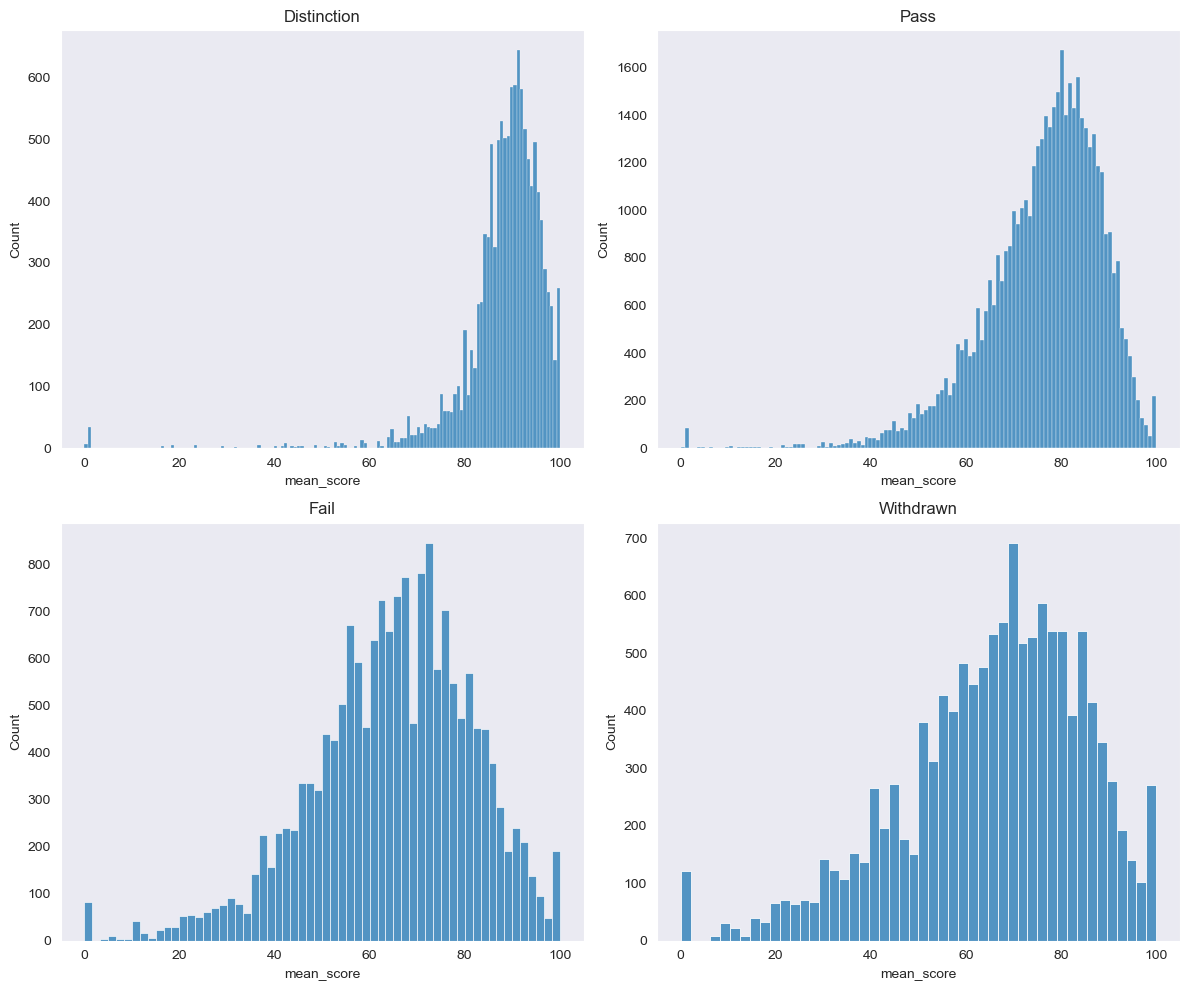

In [51]:
fig, ax = plt.subplots(2, 2, figsize = (12, 10))
sns.histplot(data = df11[df11['final_result'] == 'Distinction'], x = 'mean_score', palette = pal, ax = ax[0, 0]).set_title('Distinction')
sns.histplot(data = df11[df11['final_result'] == 'Pass'], x = 'mean_score', palette = pal, ax = ax[0, 1]).set_title('Pass')
sns.histplot(data = df11[df11['final_result'] == 'Fail'], x = 'mean_score', palette = pal, ax = ax[1, 0]).set_title('Fail')
sns.histplot(data = df11[df11['final_result'] == 'Withdrawn'], x = 'mean_score', palette = pal, ax = ax[1, 1]).set_title('Withdrawn')
plt.tight_layout()
plt.show()

In [52]:
dist_scr = np.array(df11[df11['final_result'] == 'Distinction']['mean_score'])
pass_scr = np.array(df11[df11['final_result'] == 'Pass']['mean_score'])
fail_scr = np.array(df11[df11['final_result'] == 'Fail']['mean_score'])
with_scr = np.array(df11[df11['final_result'] == 'Withdrawn']['mean_score'])

f_stat_scr, p_scr = stats.f_oneway(dist_scr, pass_scr, fail_scr, with_scr)
print(f'F-Stat: {f_stat_scr}')
print(f'P-Value: {p_scr}')

F-Stat: 8332.648681853558
P-Value: 0.0


In [53]:
comp1 = mc.MultiComparison(df11['mean_score'], df11['final_result'])
tbl_scr, a1_scr, a2_scr = comp1.allpairtest(stats.ttest_ind, alpha = 0.05, method = 'bonf')
tbl_scr

group1,group2,stat,pval,pval_corr,reject
Distinction,Fail,137.4976,0.0,0.0,True
Distinction,Pass,98.4631,0.0,0.0,True
Distinction,Withdrawn,115.9946,0.0,0.0,True
Fail,Pass,-94.4053,0.0,0.0,True
Fail,Withdrawn,-3.8298,0.0001,0.0008,True
Pass,Withdrawn,75.4599,0.0,0.0,True


In [54]:
dist_mean = df4[df4['final_result'] == 'Distinction']['score'].mean()
dist_std = df4[df4['final_result'] == 'Distinction']['score'].std()
pass_mean = df4[df4['final_result'] == 'Pass']['score'].mean()
pass_std = df4[df4['final_result'] == 'Pass']['score'].std()
fail_mean = df4[df4['final_result'] == 'Fail']['score'].mean()
fail_std = df4[df4['final_result'] == 'Fail']['score'].std()
with_mean = df4[df4['final_result'] == 'Withdrawn']['score'].mean()
with_std = df4[df4['final_result'] == 'Withdrawn']['score'].std()

print(f'Distinction: {dist_mean} +- {dist_std}')
print(f'Pass: {pass_mean} +- {pass_std}')
print(f'Fail: {fail_mean} +- {fail_std}')
print(f'Withdrawn: {with_mean} +- {with_std}')

Distinction: 89.28061673447004 +- 10.280200108731458
Pass: 77.02986676258561 +- 15.588004077477752
Fail: 65.14790255592676 +- 19.99475762950118
Withdrawn: 63.74484745512299 +- 23.397600837011304


Notably, the scores between the four final results have roughly the same mean. Because this is initial exploratory analysis, the data has not yet been normalized so the t-test results will be reassessed after modeling. The key factor that may distinguish the four groups is the sample sizes of each group that impact the variances. These differences were detected by the one-way ANOVA so the machine learning model should be able to detect these distinctions.

## How does the material interaction (average active time and assessment length) for each assignment differ between the final results?

Increase the amount spent with the material may indicate a student that is taking special care with the assignment or a student that is dedicated enough to see it through. Longer amounts of time could also indicate a concept that is a little too difficult to grasp or some confounding factors outside of a student's control.

For this question in particular, the number of times a student interacts with the material will be assessed along with how long the material took to complete.

In [57]:
al_a, al_b = np.polyfit(df11['mean_assessment_length'], df11['mean_active'], 1)
al_x_theor = np.array(range(int(df11['mean_assessment_length'].min()), int(df11['mean_assessment_length'].max())))
al_y_theor = (al_a * al_x_theor) + al_b

C:\Users\jacob\AppData\Local\Temp\ipykernel_36272\3606635141.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  act_len_reg = sns.lineplot(x = al_x_theor, y = al_y_theor, palette = pal, color = 'red')
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\AppData\Local\Temp\ipykernel_36272\3606635141.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  act_len_reg = sns.scatterplot(data = df11, y = 'mean_active', x = 'mean_assessment_leng

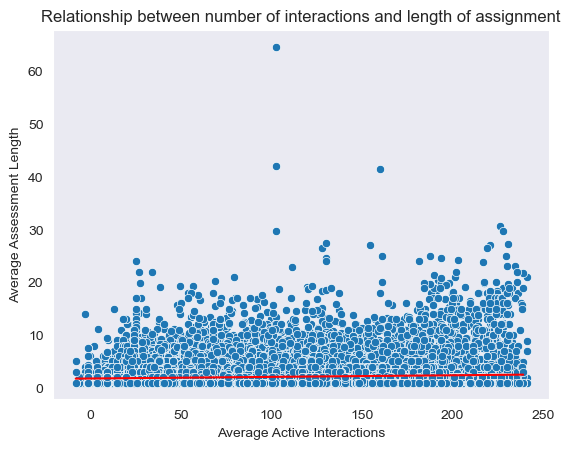

In [58]:
act_len_reg = sns.lineplot(x = al_x_theor, y = al_y_theor, palette = pal, color = 'red')
act_len_reg = sns.scatterplot(data = df11, y = 'mean_active', x = 'mean_assessment_length', palette = pal)
act_len_reg = plt.xlabel('Average Active Interactions')
act_len_reg = plt.ylabel('Average Assessment Length')
act_len_reg = plt.title('Relationship between number of interactions and length of assignment')
plt.show()

In [59]:
ald_a, ald_b = np.polyfit(df11[df11['final_result'] == 'Distinction']['mean_assessment_length'],
                          df11[df11['final_result'] == 'Distinction']['mean_active'], 1)
ald_x_theor = np.array(range(int(df11[df11['final_result'] == 'Distinction']['mean_assessment_length'].min()),
                             int(df11[df11['final_result'] == 'Distinction']['mean_assessment_length'].max())))
ald_y_theor = (ald_a * ald_x_theor) + ald_b

In [60]:
alp_a, alp_b = np.polyfit(df11[df11['final_result'] == 'Pass']['mean_assessment_length'],
                          df11[df11['final_result'] == 'Pass']['mean_active'], 1)
alp_x_theor = np.array(range(int(df11[df11['final_result'] == 'Pass']['mean_assessment_length'].min()),
                             int(df11[df11['final_result'] == 'Pass']['mean_assessment_length'].max())))
alp_y_theor = (alp_a * alp_x_theor) + alp_b

In [61]:
alf_a, alf_b = np.polyfit(df11[df11['final_result'] == 'Fail']['mean_assessment_length'],
                          df11[df11['final_result'] == 'Fail']['mean_active'], 1)
alf_x_theor = np.array(range(int(df11[df11['final_result'] == 'Fail']['mean_assessment_length'].min()),
                             int(df11[df11['final_result'] == 'Fail']['mean_assessment_length'].max())))
alf_y_theor = (alf_a * alf_x_theor) + alf_b

In [62]:
alw_a, alw_b = np.polyfit(df11[df11['final_result'] == 'Withdrawn']['mean_assessment_length'],
                          df11[df11['final_result'] == 'Withdrawn']['mean_active'], 1)
alw_x_theor = np.array(range(int(df11[df11['final_result'] == 'Withdrawn']['mean_assessment_length'].min()),
                             int(df11[df11['final_result'] == 'Withdrawn']['mean_assessment_length'].max())))
alw_y_theor = (alw_a * alw_x_theor) + alw_b

C:\Users\jacob\AppData\Local\Temp\ipykernel_36272\759819192.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x = ald_x_theor, y = ald_y_theor, palette = pal, color = 'red', ax = ax[0, 0])
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\AppData\Local\Temp\ipykernel_36272\759819192.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x = alp_x_theor, y = alp_y_theor, palette = pal, color = 'red', ax = ax[0

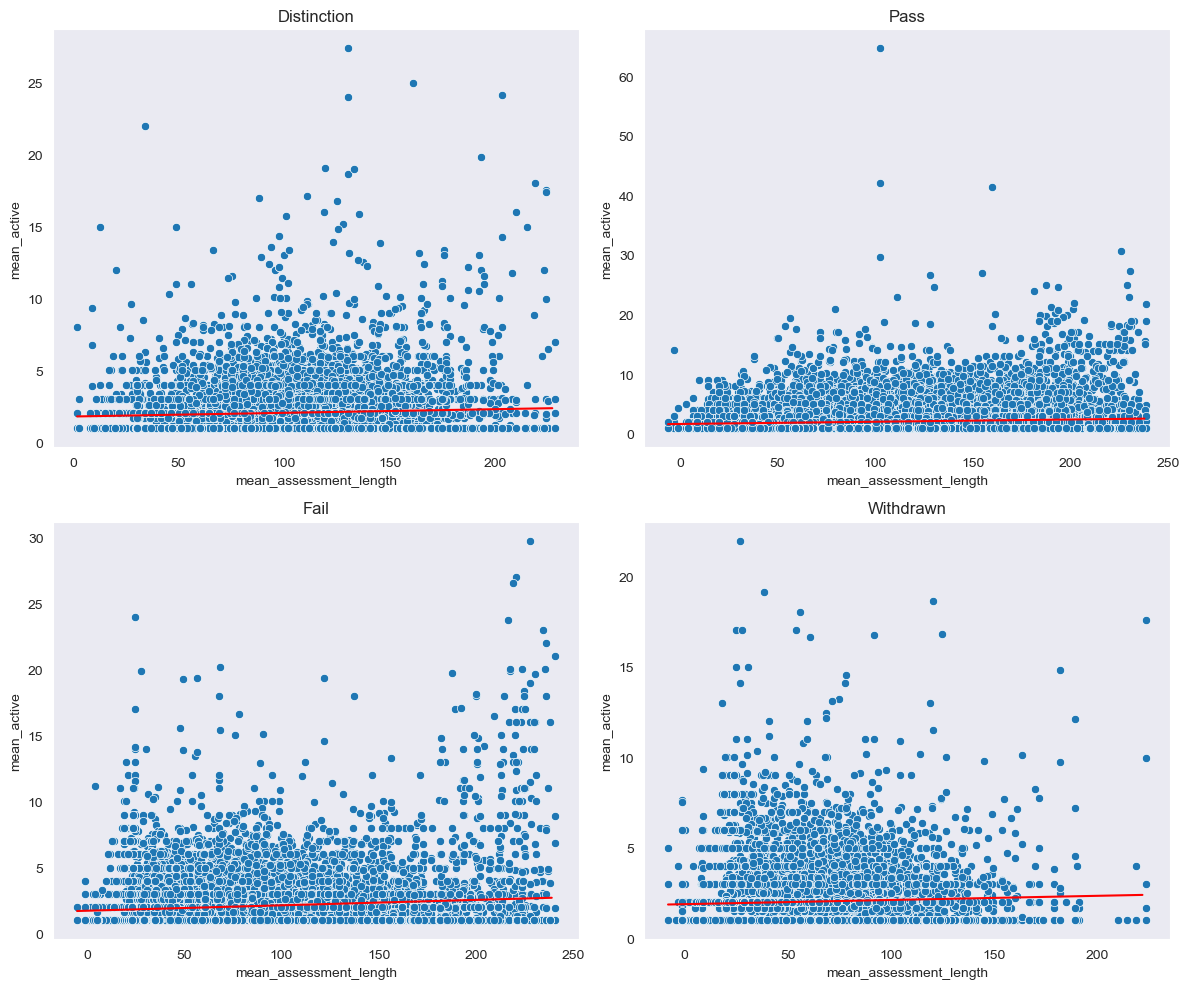

In [63]:
fig, ax = plt.subplots(2, 2, figsize = (12, 10))
sns.lineplot(x = ald_x_theor, y = ald_y_theor, palette = pal, color = 'red', ax = ax[0, 0])
sns.lineplot(x = alp_x_theor, y = alp_y_theor, palette = pal, color = 'red', ax = ax[0, 1])
sns.lineplot(x = alf_x_theor, y = alf_y_theor, palette = pal, color = 'red', ax = ax[1, 0])
sns.lineplot(x = alw_x_theor, y = alw_y_theor, palette = pal, color = 'red', ax = ax[1, 1])
sns.scatterplot(data = df11[df11['final_result'] == 'Distinction'], y = 'mean_active', x = 'mean_assessment_length', palette = pal, ax = ax[0, 0]).set_title('Distinction')
sns.scatterplot(data = df11[df11['final_result'] == 'Pass'], y = 'mean_active', x = 'mean_assessment_length', palette = pal, ax = ax[0, 1]).set_title('Pass')
sns.scatterplot(data = df11[df11['final_result'] == 'Fail'], y = 'mean_active', x = 'mean_assessment_length', palette = pal, ax = ax[1, 0]).set_title('Fail')
sns.scatterplot(data = df11[df11['final_result'] == 'Withdrawn'], y = 'mean_active', x = 'mean_assessment_length', palette = pal, ax = ax[1, 1]).set_title('Withdrawn')
plt.tight_layout()
plt.show()

### Number of interactions

The number of interactions as represented by the number of days a student persisted with the material actively could indicate a number of things in proportion to how long the assignment took to complete. The 'mean_active' feature is more robust to other assignments which may have overlapped with eachother. By characterizing students average proactivity per assignment, their dedication and intensity towards the asignments can be quantified.

C:\Users\jacob\AppData\Local\Temp\ipykernel_36272\2412275834.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df11[df11['final_result'] == 'Distinction'], x = 'mean_active', palette = pal, ax = ax[0, 0]).set_title('Distinction')
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\AppData\Local\Temp\ipykernel_36272\2412275834.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df11[df11['final_result'] == 'Pass'], x = 'mean_active', palette = pal, ax = ax[0, 1]).set_title('Pass')
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

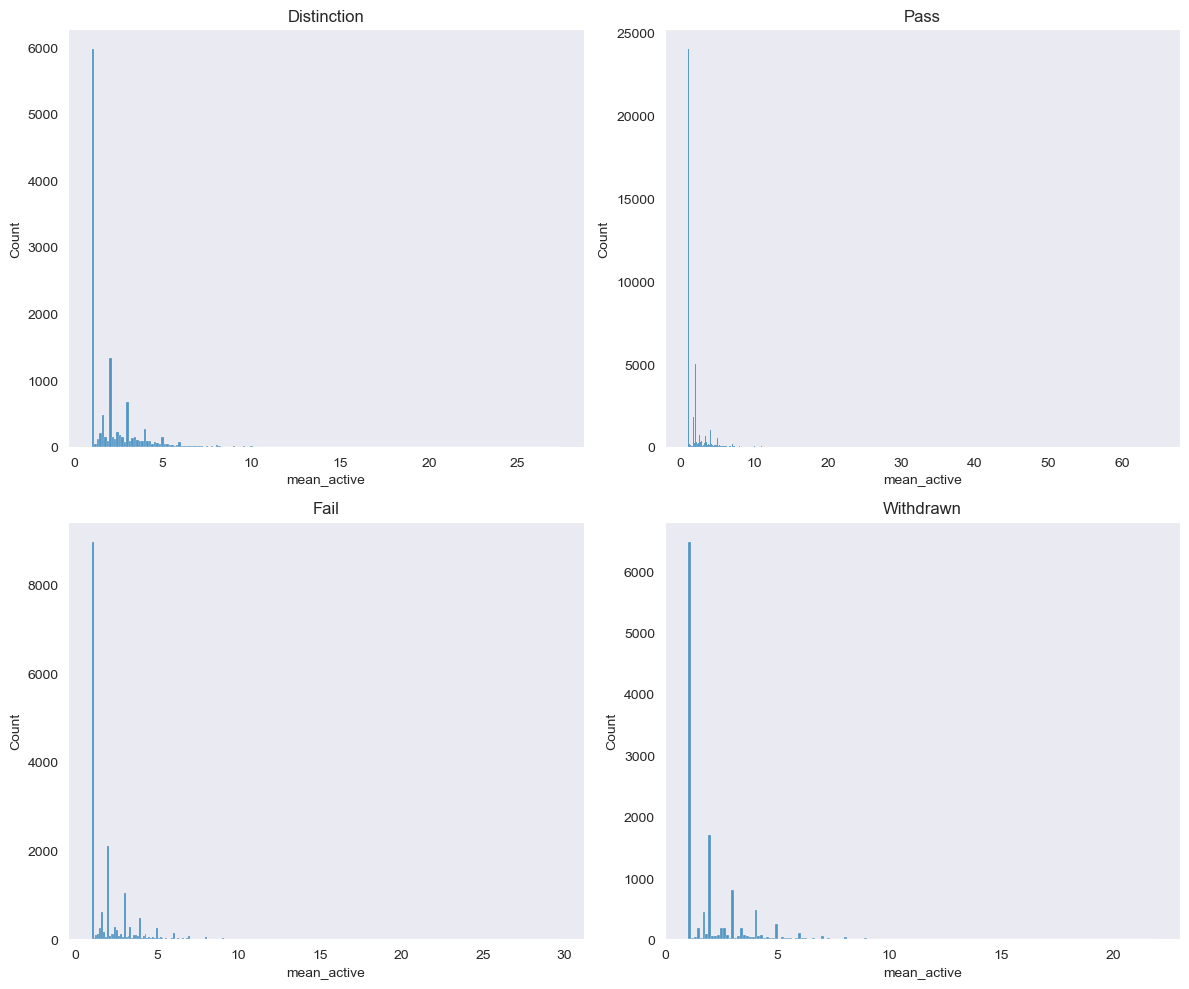

In [65]:
fig, ax = plt.subplots(2, 2, figsize = (12, 10))
sns.histplot(data = df11[df11['final_result'] == 'Distinction'], x = 'mean_active', palette = pal, ax = ax[0, 0]).set_title('Distinction')
sns.histplot(data = df11[df11['final_result'] == 'Pass'], x = 'mean_active', palette = pal, ax = ax[0, 1]).set_title('Pass')
sns.histplot(data = df11[df11['final_result'] == 'Fail'], x = 'mean_active', palette = pal, ax = ax[1, 0]).set_title('Fail')
sns.histplot(data = df11[df11['final_result'] == 'Withdrawn'], x = 'mean_active', palette = pal, ax = ax[1, 1]).set_title('Withdrawn')
plt.tight_layout()
plt.show()

In [66]:
dist_act = np.array(df11[df11['final_result'] == 'Distinction']['mean_active'])
pass_act = np.array(df11[df11['final_result'] == 'Pass']['mean_active'])
fail_act = np.array(df11[df11['final_result'] == 'Fail']['mean_active'])
with_act = np.array(df11[df11['final_result'] == 'Withdrawn']['mean_active'])

In [68]:
print(f'Distinction Mode: {stats.mode(dist_act)}')
print(f'Pass Mode: {stats.mode(pass_act)}')
print(f'Fail Mode: {stats.mode(fail_act)}')
print(f'Withdrawn Mode: {stats.mode(with_act)}')

Distinction Mode: ModeResult(mode=1.0, count=5968)
Pass Mode: ModeResult(mode=1.0, count=24018)
Fail Mode: ModeResult(mode=1.0, count=8965)
Withdrawn Mode: ModeResult(mode=1.0, count=6482)


In [70]:
f_stat_act, p_act = stats.f_oneway(dist_act, pass_act, fail_act, with_act)
print(f'F-Stat: {f_stat_act}')
print(f'P-Value: {p_act}')

F-Stat: 2.2564919839436115
P-Value: 0.0796275720078633


In [72]:
comp2 = mc.MultiComparison(df11['mean_active'], df11['final_result'])
tbl_act, a1_act, a2_act = comp2.allpairtest(stats.ttest_ind, alpha = 0.05, method = 'bonf')
tbl_act

group1,group2,stat,pval,pval_corr,reject
Distinction,Fail,-0.4756,0.6344,1.0,False
Distinction,Pass,0.1133,0.9098,1.0,False
Distinction,Withdrawn,1.9624,0.0497,0.2984,False
Fail,Pass,0.7552,0.4502,1.0,False
Fail,Withdrawn,2.5189,0.0118,0.0707,False
Pass,Withdrawn,2.2188,0.0265,0.159,False
